Running on device: cuda:0
GPU Name: NVIDIA GeForce RTX 3060


d:\MobileEmuMaster\anaconda3\envs\pytorch\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


NaN or large loss detected at epoch 6, loading best model
Epoch 10/100 | Loss: 4.2712e+00 | PDE: 1.3469e-01 | Error: 3.9586e-02
Epoch 20/100 | Loss: 3.3540e+00 | PDE: 9.3720e-02 | Error: 1.1452e-01
Epoch 30/100 | Loss: 1.9794e+00 | PDE: 1.7688e-01 | Error: 2.5214e-01
Epoch 40/100 | Loss: 1.7210e+00 | PDE: 2.9659e-01 | Error: 3.0290e-01
Epoch 50/100 | Loss: 1.4763e+00 | PDE: 2.2515e-01 | Error: 2.7355e-01
Epoch 60/100 | Loss: 1.3244e+00 | PDE: 1.5371e-01 | Error: 2.2243e-01
Epoch 70/100 | Loss: 1.2138e+00 | PDE: 1.3465e-01 | Error: 1.8953e-01
Epoch 80/100 | Loss: 1.1280e+00 | PDE: 1.2967e-01 | Error: 1.7485e-01
Epoch 90/100 | Loss: 1.0682e+00 | PDE: 1.1506e-01 | Error: 1.5383e-01
Epoch 100/100 | Loss: 1.0226e+00 | PDE: 1.0045e-01 | Error: 1.3080e-01


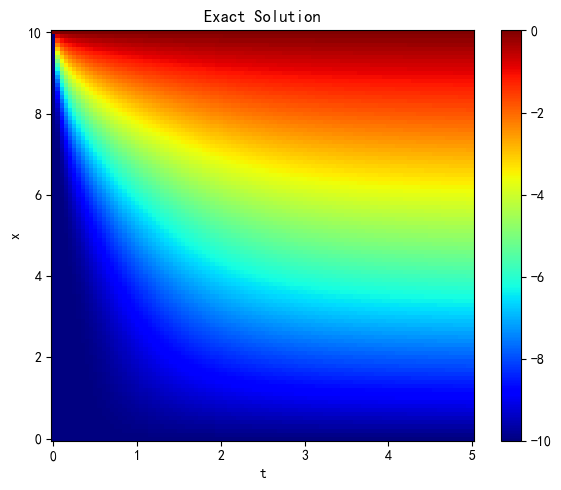

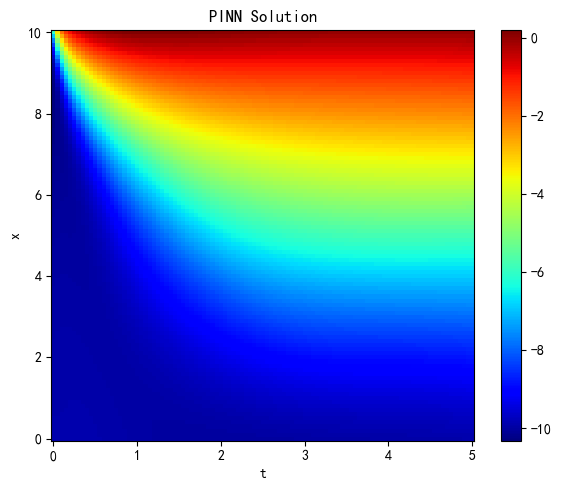

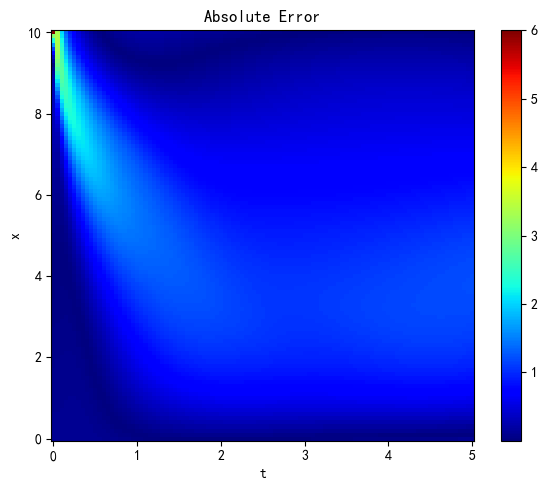

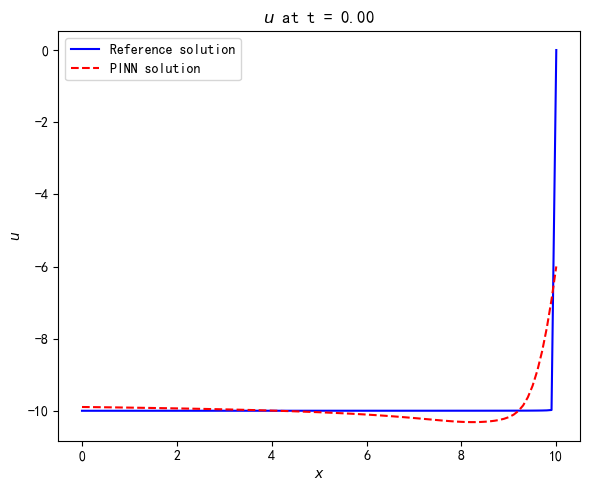

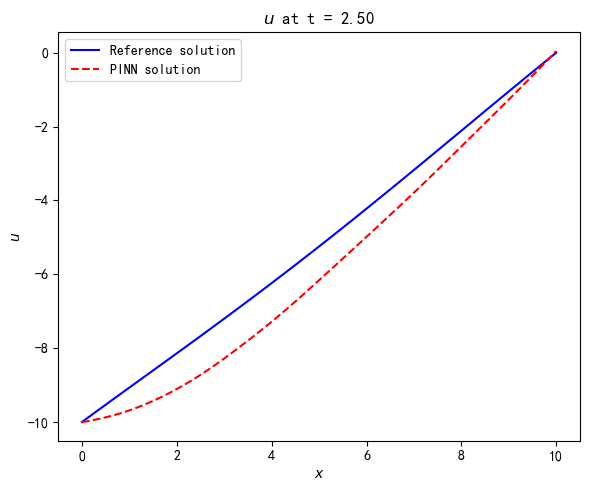

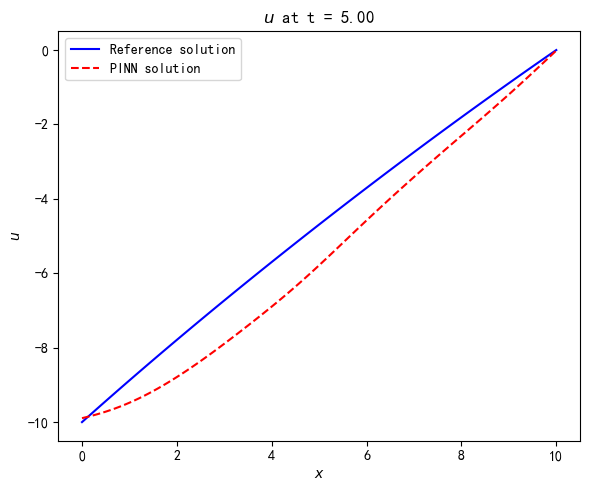

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.optim import LBFGS
from torch.nn.utils.parametrizations import weight_norm
import pandas as pd
import time

# Set matplotlib font to handle Chinese characters
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# Set random seed for reproducibility
init_seed = 0
np.random.seed(init_seed)
torch.manual_seed(init_seed)
torch.cuda.manual_seed(init_seed)
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False

# Confirm the device (CUDA or CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")
if device.type == "cuda":
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

def fwd_gradients(Y, x):
    """Compute the gradients of Y with respect to x."""
    dummy = torch.ones_like(Y)
    G = torch.autograd.grad(Y, x, dummy, create_graph=True)[0]
    return G

class Net(torch.nn.Module):
    def __init__(self, layer_dim, X, device):
        super().__init__()
        self.X_mean = torch.from_numpy(X.mean(0, keepdims=True)).float().to(device)
        self.X_std = torch.from_numpy(X.std(0, keepdims=True)).float().to(device)
        
        self.num_layers = len(layer_dim)
        temp = []
        for l in range(1, self.num_layers):
            layer = torch.nn.Linear(layer_dim[l-1], layer_dim[l])
            layer = weight_norm(layer, name='weight', dim=0)
            torch.nn.init.normal_(layer.weight)
            temp.append(layer)
        self.layers = torch.nn.ModuleList(temp).to(device)
        
    def forward(self, x):
        """Forward pass through the network with input normalization and activations."""
        x = ((x - self.X_mean) / self.X_std)
        for i in range(0, self.num_layers-1):
            x = self.layers[i](x)
            if i < self.num_layers-2:
                x = torch.nn.functional.tanh(x)
        return x

class PINN():
    def __init__(self, layers, device):
        """Initialize the Physics-Informed Neural Network (PINN)."""
        self.Nx = 101
        self.Nt = 101
        self.layers = layers
        self.device = device
        
        # Generate reference grid points
        t = torch.linspace(0.0, 5.0, self.Nt, device=device)
        x = torch.linspace(0.0, 10.0, self.Nx, device=device)
        xx, tt = torch.meshgrid(x, t, indexing='ij')
        self.X_ref = torch.cat([xx.reshape(-1,1), tt.reshape(-1,1)], dim=1).requires_grad_(True)
        
        # Initial conditions
        self.X_ic = torch.cat([xx[:, [0]], tt[:, [0]]], dim=1)
        self.u_ic = torch.full_like(xx[:, [0]], -10, dtype=torch.float32, device=self.device)
        
        # Boundary conditions
        self.X_lbc = torch.cat([xx[[0]], tt[[0]]], dim=0).T.requires_grad_(True)
        self.X_ubc = torch.cat([xx[[-1]], tt[[-1]]], dim=0).T.requires_grad_(True)

        # Logging
        self.log = {'losses':[], 'losses_b':[], 'losses_i':[], 'losses_f':[], 'losses_s':[], 'mse_exact':[], 'time':[]}
        
        self.min_loss = 1
        self.model = Net(layers, self.X_ref.cpu().detach().numpy(), self.device).to(self.device)

    def exact_solution(self, z, t, alpha=0.016, beta_deg=33, L=10, psi_d=-10, c=0.104):
        """
        Exact solution for the transient infiltration problem.
        Parameters:
            z (torch.Tensor): Spatial grid points.
            t (torch.Tensor): Temporal grid points.
            alpha, beta_deg, L, psi_d, c: Parameters for the exact solution.
        Returns:
            torch.Tensor: Exact solution at the given (z, t) points.
        """
        beta = torch.tensor(beta_deg * torch.pi / 180.0, dtype=torch.float32, device=self.device)
        z = z.to(self.device, dtype=torch.float32)
        t = t.to(self.device, dtype=torch.float32)
        
        alpha = torch.tensor(alpha, dtype=torch.float32, device=self.device)
        psi_d = torch.tensor(psi_d, dtype=torch.float32, device=self.device)
        L = torch.tensor(L, dtype=torch.float32, device=self.device)
        c = torch.tensor(c, dtype=torch.float32, device=self.device)

        part_1 = (1 - torch.exp(alpha * psi_d)) * (1 - torch.exp(-alpha * torch.cos(beta) * z)) / (1 - torch.exp(-alpha * torch.cos(beta) * L))

        sum_terms = 0
        for k in range(1, 9999):
            lambda_k = k * torch.pi / L
            mu_k = (alpha**2 / 4 + lambda_k**2) / c
            sum_terms += ((-1) ** k) * (lambda_k / mu_k) * torch.sin(lambda_k * z) * torch.exp(-mu_k * t)

        part_2 = (2 * (1 - torch.exp(alpha * psi_d)) / (L * c)) * torch.exp(alpha * torch.cos(beta) * (L - z) / 2) * sum_terms

        u_true = 1/alpha * torch.log(part_1 + part_2 + torch.exp(alpha * psi_d))
        return u_true

    def Msei(self):
        """Initial condition loss (mean squared error between predicted and initial condition values)."""
        u = self.model(self.X_ic)
        msei = F.mse_loss(u, self.u_ic)
        return msei
    
    def Mseb(self):
        """Boundary condition loss (mean squared error between predicted and boundary condition values)."""
        u_lbc = self.model(self.X_lbc)
        u_ubc = self.model(self.X_ubc)
        mseb = F.mse_loss(u_lbc, torch.full_like(u_lbc, -10, device=self.device)) + \
               F.mse_loss(u_ubc, torch.full_like(u_ubc, 0, device=self.device))
        return mseb
    
    def Msef(self):
        """PDE residual loss (based on the differential equation)."""
        beta = torch.tensor(33 * torch.pi / 180.0, dtype=torch.float32, device=self.device)
    
        u = self.model(self.X_ref)
        u_xt = fwd_gradients(u, self.X_ref)
        u_x = u_xt[:,0:1]
        u_t = u_xt[:,1:2]
        u_xx = fwd_gradients(u_x, self.X_ref)[:,0:1]

        f = u_t * 0.016 * 0.39 / 0.06 - u_xx - 0.016 * torch.cos(beta) * u_x - 0.016 * u_x ** 2
        msef = torch.mean(f**2)
        return msef
    
    def Mses(self):
        """Relative L2 error between predicted solution and exact solution."""
        z = self.X_ref[:, 0:1]
        t = self.X_ref[:, 1:2]
        u_true = self.exact_solution(z, t)
        u_pred = self.model(self.X_ref)
        mses = torch.norm(u_pred - u_true) / torch.norm(u_true)
        return mses

    def Loss(self):
        """Total loss (sum of initial, boundary, PDE, and relative error losses)."""
        msei = self.Msei()
        mseb = self.Mseb()
        msef = self.Msef()
        loss = msei + mseb + msef
        return loss, msei, mseb, msef

    def train(self, epochs):
        """Train the model for a given number of epochs."""
        t_start = time.time()
        best_mse = float('inf')
        
        optimizer = LBFGS(self.model.parameters(), max_iter=100)
        
        for epoch in range(epochs):
            def closure():
                optimizer.zero_grad()
                loss, loss_i, loss_b, loss_f = self.Loss()
                loss.backward()
                return loss
            
            optimizer.step(closure)
            
            loss_s = self.Mses()
            z = self.X_ref[:, 0:1]
            t = self.X_ref[:, 1:2]
            u_true = self.exact_solution(z, t)
            u_pred = self.model(self.X_ref)
            mse_exact = F.mse_loss(u_pred, u_true)
            
            t_end = time.time()
            elapsed = t_end - t_start
            self.log['time'].append(elapsed)
            t_start = time.time()
            
            loss_val = closure()
            self.log['losses'].append(loss_val.item())
            self.log['losses_f'].append(self.Msef().item())
            self.log['losses_b'].append(self.Mseb().item())
            self.log['losses_i'].append(self.Msei().item())
            self.log['losses_s'].append(loss_s.item())
            self.log['mse_exact'].append(mse_exact.item())
            
            if mse_exact.item() < best_mse:
                best_mse = mse_exact.item()
                torch.save(self.model.state_dict(), 'best_model_pinn.pth')
            
            if torch.isnan(loss_val) or (epoch > 0 and loss_val.item() > 3 * self.log['losses'][-2]):
                if epoch == 0:
                    print("NaN or large loss detected at epoch 0, reinitializing model")
                    self.model = Net(self.layers, self.X_ref.cpu().detach().numpy(), self.device).to(self.device)
                    optimizer = LBFGS(self.model.parameters(), max_iter=20, lr=1.0)
                    continue
                else:
                    print(f"NaN or large loss detected at epoch {epoch+1}, loading best model")
                    self.model.load_state_dict(torch.load('best_model_pinn.pth'))
                    optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
                    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)
                    continue
            
            if (epoch+1) % 10 == 0 or (epoch+1) == epochs:
                print(f'Epoch {epoch+1}/{epochs} | Loss: {self.log["losses"][-1]:.4e} | PDE: {self.log["losses_f"][-1]:.4e} | Error: {self.log["losses_s"][-1]:.4e}')

if __name__ == '__main__':
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    layers = [2, 128, 128, 128, 128, 1]
    
    pinn = PINN(layers, device)
    pinn.train(100)
    
    # Data preparation
    XX = pinn.X_ref[:, 0].cpu().detach().numpy().reshape(pinn.Nx, pinn.Nt)
    TT = pinn.X_ref[:, 1].cpu().detach().numpy().reshape(pinn.Nx, pinn.Nt)
    z = pinn.X_ref[:, 0:1]
    t = pinn.X_ref[:, 1:2]
    u_pred = pinn.model(pinn.X_ref).cpu().detach().numpy().reshape(pinn.Nx, pinn.Nt)
    u_true = pinn.exact_solution(z, t).cpu().detach().numpy().reshape(pinn.Nx, pinn.Nt)
    error = np.abs(u_true - u_pred)

    # Save six separate TIFF images
    plt.figure(figsize=(6, 5), dpi=300)
    c1 = plt.pcolormesh(TT, XX, u_true, cmap='jet', vmin=-10, vmax=0)
    plt.colorbar(c1)
    plt.title('Exact Solution')
    plt.xlabel('t')
    plt.ylabel('x')
    plt.tight_layout()
    plt.savefig('exact_solution.tiff', format='tiff', dpi=300)
    plt.close()

    plt.figure(figsize=(6, 5), dpi=300)
    c2 = plt.pcolormesh(TT, XX, u_pred, cmap='jet', vmin=-10, vmax=0)
    plt.colorbar(c2)
    plt.title('PINN Predicted Solution')
    plt.xlabel('t')
    plt.ylabel('x')
    plt.tight_layout()
    plt.savefig('pinn_prediction.tiff', format='tiff', dpi=300)
    plt.close()

    plt.figure(figsize=(6, 5), dpi=300)
    c3 = plt.pcolormesh(TT, XX, error, cmap='jet', vmin=-10, vmax=0)
    plt.colorbar(c3)
    plt.title('Absolute Error')
    plt.xlabel('t')
    plt.ylabel('x')
    plt.tight_layout()
    plt.savefig('absolute_error.tiff', format='tiff', dpi=300)
    plt.close()

    # Comparison at specific time points
    time_indices = [0, 50, 100]  # t = 0, t ≈ 2.5, t = 5.0
    time_labels = [f't = {TT[0, t_idx]:.2f}' for t_idx in time_indices]
    
    for idx, t_idx in enumerate(time_indices):
        plt.figure(figsize=(6, 5), dpi=300)
        plt.plot(XX[:,0], u_true[:,t_idx], label='Reference solution', color='blue')
        plt.plot(XX[:,0], u_pred[:,t_idx], '--', label='PINN solution', color='red')
        plt.xlabel('$x$')
        plt.ylabel('$u$')
        plt.title(f'$u$ at {time_labels[idx]}')
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'comparison_t_{t_idx}.tiff', format='tiff', dpi=300)
        plt.close()

    # Save data at specific time points to Excel
    data = {}
    for idx, t_idx in enumerate(time_indices):
        time_label = f't={TT[0, t_idx]:.2f}'
        data[f'x_{time_label}'] = XX[:,0]
        data[f'u_true_{time_label}'] = u_true[:,t_idx]
        data[f'u_pred_{time_label}'] = u_pred[:,t_idx]
        data[f'error_{time_label}'] = error[:,t_idx]

    df = pd.DataFrame(data)
    df.to_excel('time_step_data.xlsx', index=False)

    # Display all plots
    plt.figure(figsize=(6, 5))
    c1 = plt.pcolormesh(TT, XX, u_true, cmap='jet')
    plt.colorbar(c1)
    plt.title('Exact Solution')
    plt.xlabel('t')
    plt.ylabel('x')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 5))
    c2 = plt.pcolormesh(TT, XX, u_pred, cmap='jet')
    plt.colorbar(c2)
    plt.title('PINN Solution')
    plt.xlabel('t')
    plt.ylabel('x')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 5))
    c3 = plt.pcolormesh(TT, XX, error, cmap='jet')
    plt.colorbar(c3)
    plt.title('Absolute Error')
    plt.xlabel('t')
    plt.ylabel('x')
    plt.tight_layout()
    plt.show()

    for idx, t_idx in enumerate(time_indices):
        plt.figure(figsize=(6, 5))
        plt.plot(XX[:,0], u_true[:,t_idx], label='Reference solution', color='blue')
        plt.plot(XX[:,0], u_pred[:,t_idx], '--', label='PINN solution', color='red')
        plt.xlabel('$x$')
        plt.ylabel('$u$')
        plt.title(f'$u$ at {time_labels[idx]}')
        plt.legend()
        plt.tight_layout()
        plt.show()
